In [3]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
import os
import tensorflow as tf

In [2]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                   )
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory("VietNam_Medicinal_Plant/train",target_size=(150, 150),
                                                   batch_size= 128,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   )

test_generator = test_datagen.flow_from_directory("VietNam_Medicinal_Plant/test", target_size = (150,150), batch_size = 128,)

Found 12000 images belonging to 200 classes.
Found 8000 images belonging to 200 classes.


In [3]:
x_train, y_train = next(train_generator)
x_test, y_test  = next(test_generator)

### Fine-tuning InceptionV3

In [4]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(include_top=False,
                      weights='imagenet',
                      input_shape=(150, 150, 3))

x = base_model.layers[-1].output
x = Dropout(0.3)(x)
x = Conv2D(200, 3, strides = (1,1), activation='softmax')(x)
predictions = Flatten()(x)

inceptionv3_model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 [==============================] - 26s 0us/step


In [5]:
from tensorflow.keras.optimizers import RMSprop
for layeR in base_model.layers:
    layeR.trainable = False

for layer in base_model.layers[-8:]:
    layer.trainable = True

In [6]:
inceptionv3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [7]:
inceptionv3_model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [8]:
history = inceptionv3_model.fit(
            train_generator,
            validation_data = test_generator,
            epochs = 20,
)

Epoch 1/20
94/94 [==============================] - 159s 2s/step - loss: 6.0539 - accuracy: 0.1838 - val_loss: 3.5748 - val_accuracy: 0.3086
Epoch 2/20
94/94 [==============================] - 180s 2s/step - loss: 3.5790 - accuracy: 0.3948 - val_loss: 3.0318 - val_accuracy: 0.4015
Epoch 3/20
94/94 [==============================] - 209s 2s/step - loss: 3.0063 - accuracy: 0.4843 - val_loss: 2.8171 - val_accuracy: 0.4475
Epoch 4/20
94/94 [==============================] - 215s 2s/step - loss: 2.7582 - accuracy: 0.5272 - val_loss: 2.7585 - val_accuracy: 0.4737
Epoch 5/20
94/94 [==============================] - 222s 2s/step - loss: 2.5313 - accuracy: 0.5617 - val_loss: 2.6182 - val_accuracy: 0.4879
Epoch 6/20
94/94 [==============================] - 202s 2s/step - loss: 2.3811 - accuracy: 0.5888 - val_loss: 2.6083 - val_accuracy: 0.4972
Epoch 7/20
94/94 [==============================] - 202s 2s/step - loss: 2.2735 - accuracy: 0.6029 - val_loss: 2.6743 - val_accuracy: 0.5010
Epoch 8/20
94

In [9]:
inceptionv3_model.save('inceptionv3')

INFO:tensorflow:Assets written to: inceptionv3/assets


INFO:tensorflow:Assets written to: inceptionv3/assets


In [1]:
from tensorflow.keras.models import load_model

# Assuming you have saved the model using model.save('path/to/your/model')
model_path = '/Users/ameyaranade/Documents/xai-vnplant200/inceptionv3'

# Load the model
loaded_inceptionv3_model = load_model(model_path)

### Plots

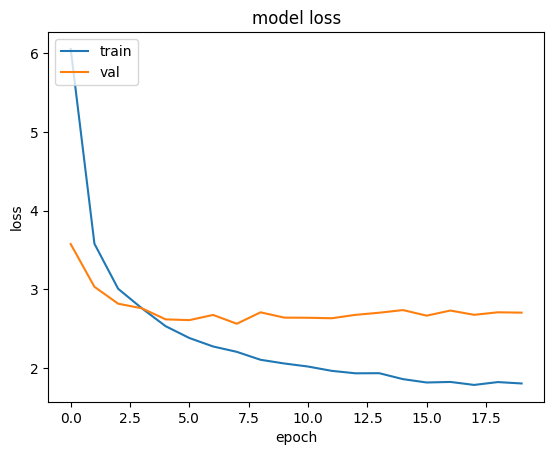

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('plots/inceptionv3_model_loss.png')

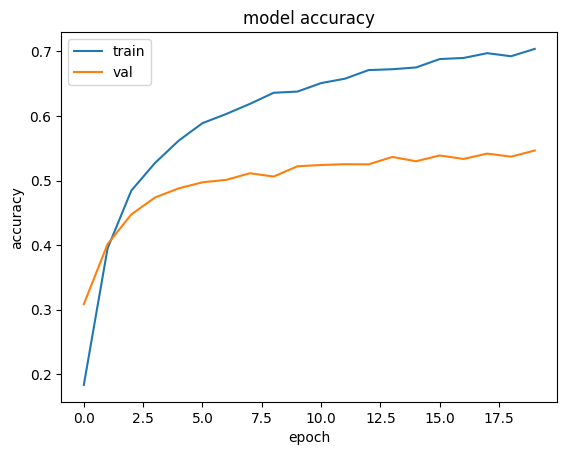

<Figure size 640x480 with 0 Axes>

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('plots/inceptionv3_model_acc.png')

In [4]:
def LoadImage(url):
    # Load image from the specified URL
    image = skimage.io.imread(url)
    return image

def transform_img(url):
    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (150,150))
    # normalizes the pixel values of the image to be in the range [-1, 1] 
    img = (img - 0.5)*2
    # adds an extra dimension to the image array to make it compatible with the input shape expected
    img = np.expand_dims(img, axis=0)
    preds = loaded_inceptionv3_model.predict(img)
    return img

### Understanding LIME using a single train image

In [5]:
import skimage

train_image_url = 'VietNam_Medicinal_Plant/train/Agave_americana/5.jpg'

inceptionv3_train_image = transform_img(train_image_url)

1/1 [==============================] - 1s 554ms/step


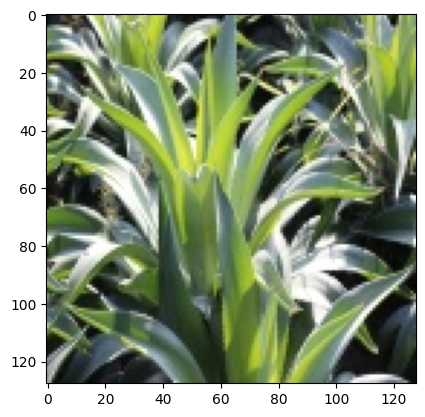

In [6]:
# Load the image
train_image_orig = LoadImage(train_image_url)

plt.imshow(train_image_orig)
plt.show()

#### LIME works by creating superpixels from an image. Let's see what superpixels are creating using different segmentation algorithms.

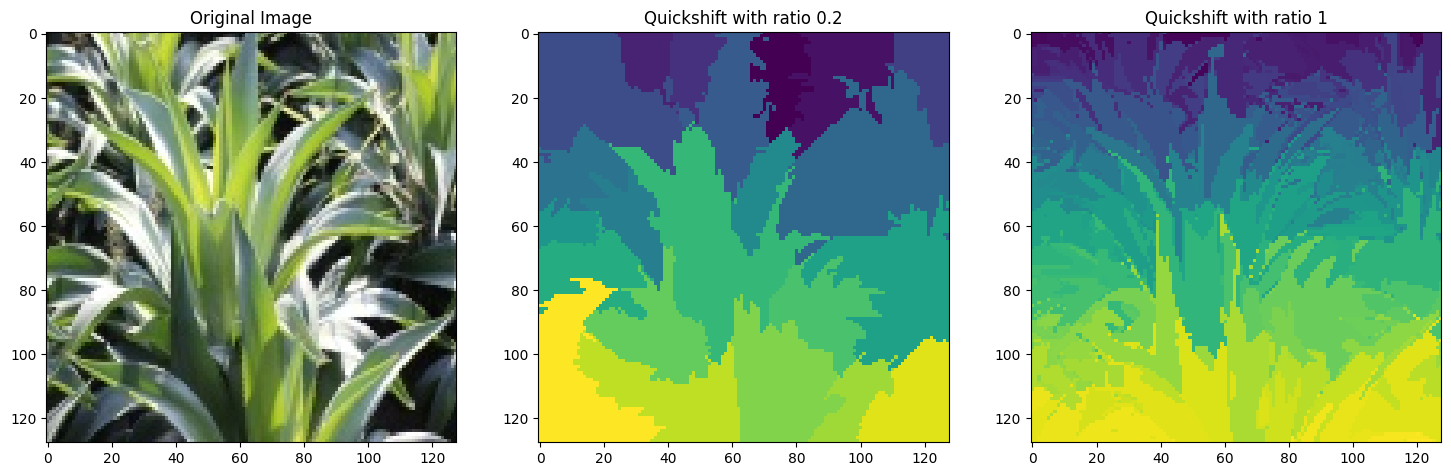

In [44]:
from skimage.segmentation import felzenszwalb, quickshift

# using the quickshift segmentation algorithm from the scikit-image library
segments = quickshift(train_image_orig)
segments1 = quickshift(train_image_orig, ratio=0.2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(train_image_orig)
ax1.set_title('Original Image')
# ax1.axis('off')

ax2.imshow(segments1)
ax2.set_title('Quickshift with ratio 0.2')
# ax2.axis('off')

ax3.imshow(segments)
ax3.set_title('Quickshift with ratio 1')
# ax3.axis('off')

plt.show()

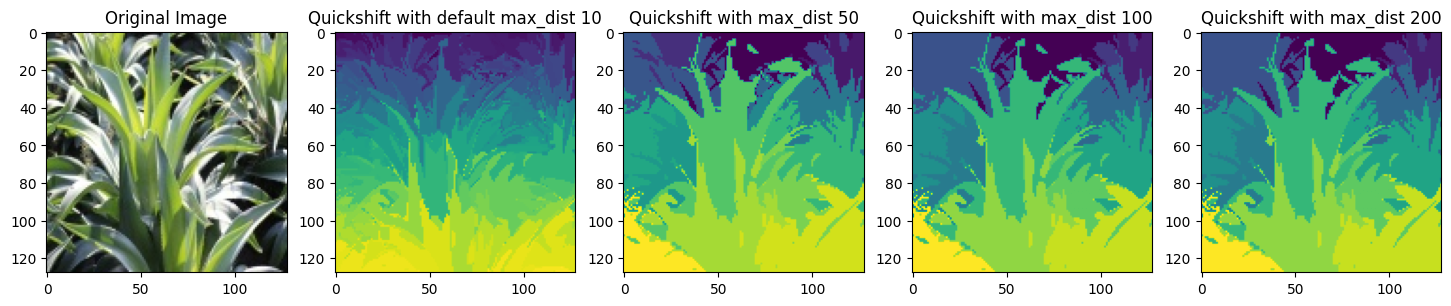

In [45]:
from skimage.segmentation import felzenszwalb, quickshift

# using the quickshift segmentation algorithm from the scikit-image library
segments2 = quickshift(train_image_orig)
segments3 = quickshift(train_image_orig, max_dist=50)
segments4 = quickshift(train_image_orig, max_dist=100)
segments5 = quickshift(train_image_orig, max_dist=200)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(18, 6))

ax1.imshow(train_image_orig)
ax1.set_title('Original Image')

ax2.imshow(segments2)
ax2.set_title('Quickshift with default max_dist 10')

ax3.imshow(segments3)
ax3.set_title('Quickshift with max_dist 50')

ax4.imshow(segments4)
ax4.set_title('Quickshift with max_dist 100')

ax5.imshow(segments5)
ax5.set_title('Quickshift with max_dist 200')

plt.show()

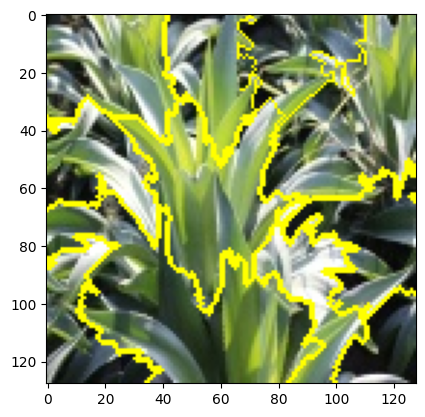

In [46]:
from skimage.segmentation import mark_boundaries

final_segments = quickshift(train_image_orig, ratio=0.2, max_dist=100)
plt.imshow(mark_boundaries(train_image_orig, final_segments))
plt.show()

[[ 1  1  1 ...  3  3  3]
 [ 1  1  1 ...  3  3  3]
 [ 1  1  1 ...  3  3  3]
 ...
 [10 10 10 ...  9  9  9]
 [10 10 10 ...  9  9  9]
 [10 10 10 ...  9  9  9]]


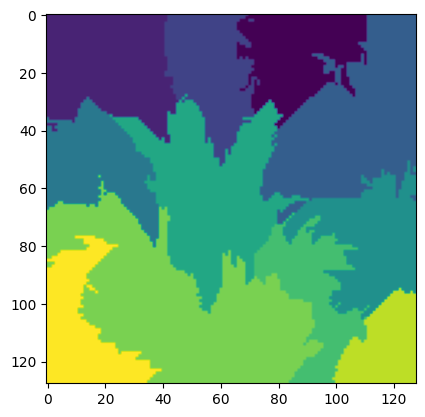

In [47]:
print(final_segments)
plt.imshow(final_segments)
plt.show()

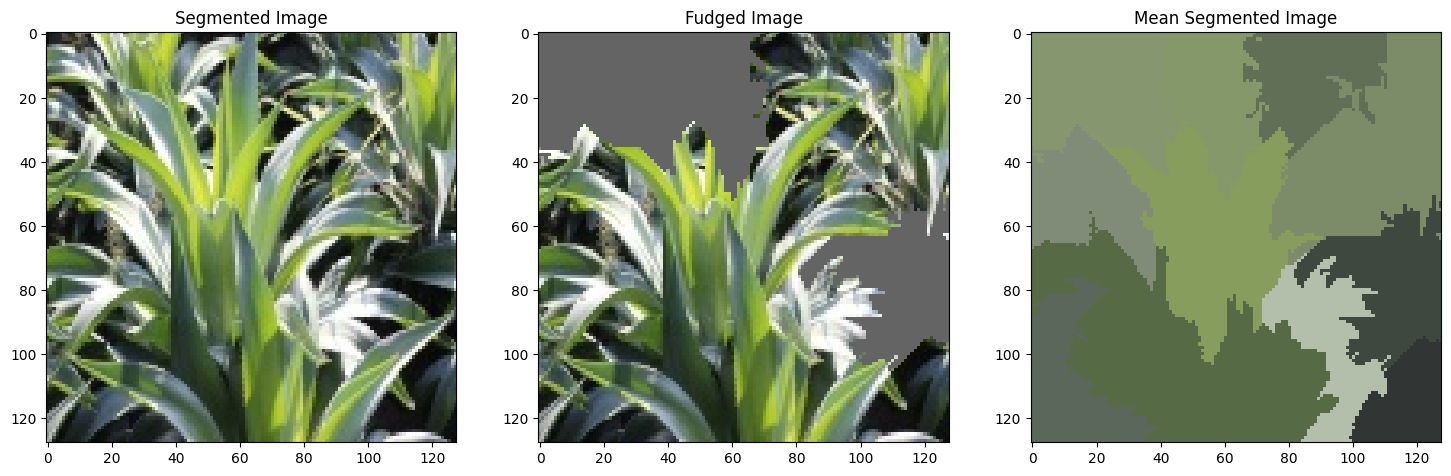

In [48]:
segmented_image = train_image_orig.copy()
fudged_image = train_image_orig.copy()
mean_segmented_image = train_image_orig.copy()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Isolate a few segments
segmented_image[final_segments == 11] = 100
segmented_image[final_segments == 28] = 100
segmented_image[final_segments == 16] = 100
segmented_image[final_segments == 55] = 100
segmented_image[final_segments == 56] = 100

# Isolate a few segments
fudged_image[final_segments == 1] = 100
fudged_image[final_segments == 2] = 100
fudged_image[final_segments == 18] = 100
fudged_image[final_segments == 5] = 100
fudged_image[final_segments == 36] = 100

# Replace superpixel with average of the pixel values
for x in np.unique(final_segments):
    # Calculate the mean pixel values for each channel (R, G, B)
    mean_pixel_values = np.mean(train_image_orig[final_segments == x], axis=0)

    # Assign the mean pixel values to all pixels within the current superpixel
    mean_segmented_image[final_segments == x] = mean_pixel_values

ax1.imshow(segmented_image)
ax1.set_title('Segmented Image')

ax2.imshow(fudged_image)
ax2.set_title('Fudged Image')

ax3.imshow(mean_segmented_image)
ax3.set_title('Mean Segmented Image')

plt.show()

### Integrating explainability using LIME

In [49]:
import lime
from tensorflow.keras.applications import inception_v3 as inc_net
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [50]:
explanation = explainer.explain_instance(inceptionv3_train_image[0].astype('double'), loaded_inceptionv3_model.predict,  top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step


Prediction class:  5


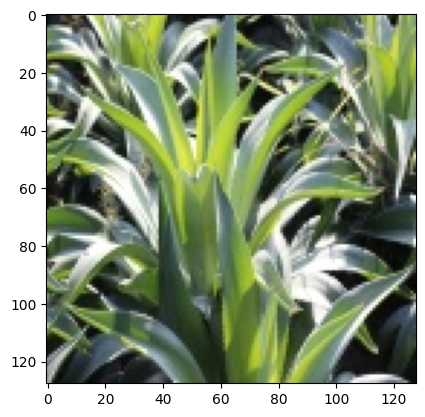

In [51]:
print('Prediction class: ', explanation.top_labels[0])
plt.imshow(train_image_orig)
plt.show()

1. hide_color - indicates that we’ll turn off superpixel regions by replacing them with gray pixels. 
2. num_features - indicates how many features to use in the explanation. Fewer features lead to more simple, understandable explanations. However, for more complex models it may be necessary to keep this value large (the default is num_features=100000).
3. set positive_only to False - to see which superpixel regions provide a negative contribution.

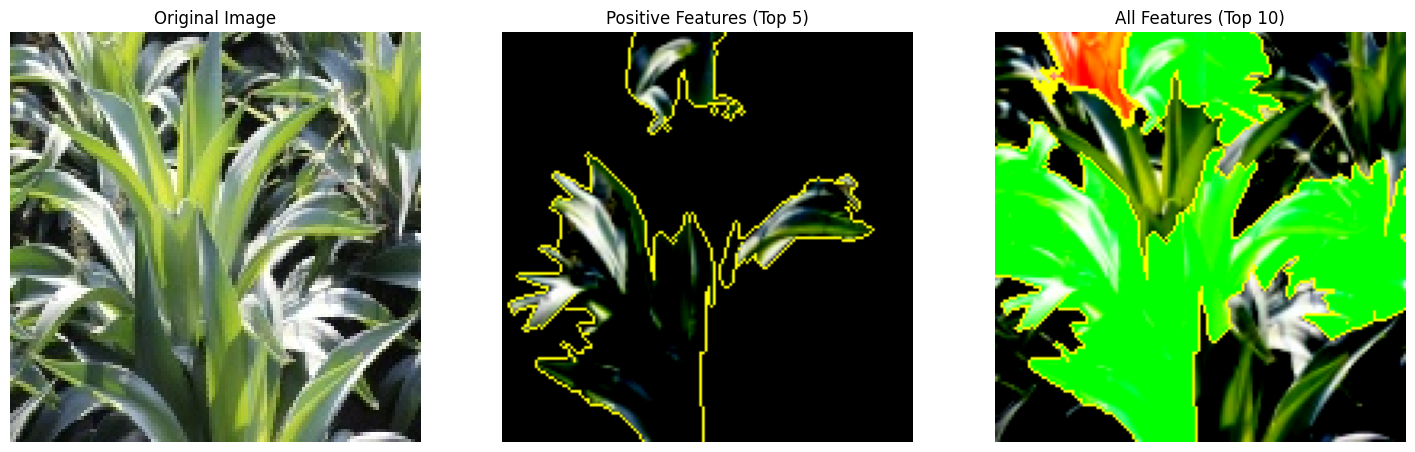

In [52]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

# To get an overlay of the superpixels with positive influence, we change the arguments positive_only and hide_rest to False
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(train_image_orig)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(mark_boundaries(temp_1, mask_1))
ax2.set_title('Positive Features (Top 5)')
ax2.axis('off')

ax3.imshow(mark_boundaries(temp_2, mask_2))
ax3.set_title('All Features (Top 10)')
ax3.axis('off')

plt.savefig('plots/inceptionv3_model_explanations_train_class_5.png')

In [53]:
explanation.top_labels[1]

57

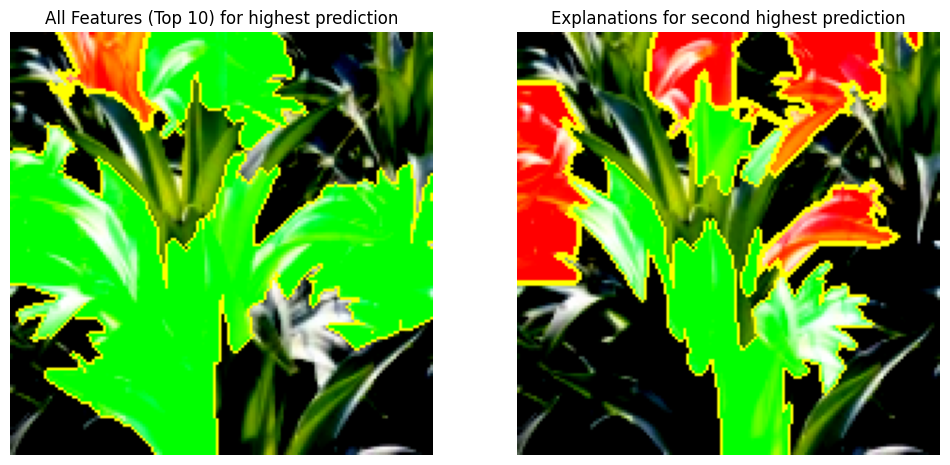

In [54]:
second_temp, second_mask = explanation.get_image_and_mask(label=explanation.top_labels[1],
                                            positive_only=False,
                                            num_features=10,
                                            hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(mark_boundaries(temp_2, mask_2))
ax1.set_title('All Features (Top 10) for highest prediction')
ax1.axis('off')

ax2.imshow(mark_boundaries(second_temp, second_mask))
ax2.set_title('Explanations for second highest prediction')
ax2.axis('off')

plt.savefig('plots/inceptionv3_model_explanations_train_class_5_second_prediction.png')

### Checking LIME explanation on test image

In [55]:
test_image_url = 'VietNam_Medicinal_Plant/test/Blackberry_Lily/60.JPG'

inceptionv3_test_image = transform_img(test_image_url)

1/1 [==============================] - 0s 23ms/step


In [57]:
test_explanation = explainer.explain_instance(inceptionv3_test_image[0].astype('double'), loaded_inceptionv3_model.predict,  top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 79ms/step


#### Prediction is correct. Class 29 corresponds to 'Blackberry_Lily'.

Prediction class:  29


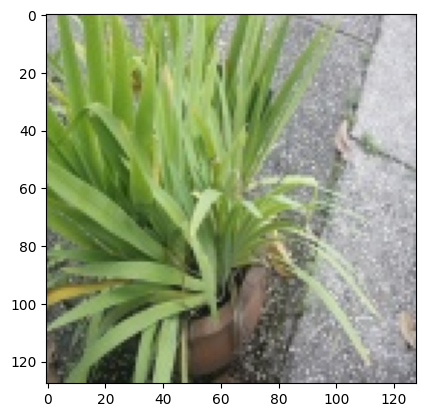

In [58]:
print('Prediction class: ', test_explanation.top_labels[0])
plt.imshow(test_image_orig)
plt.show()

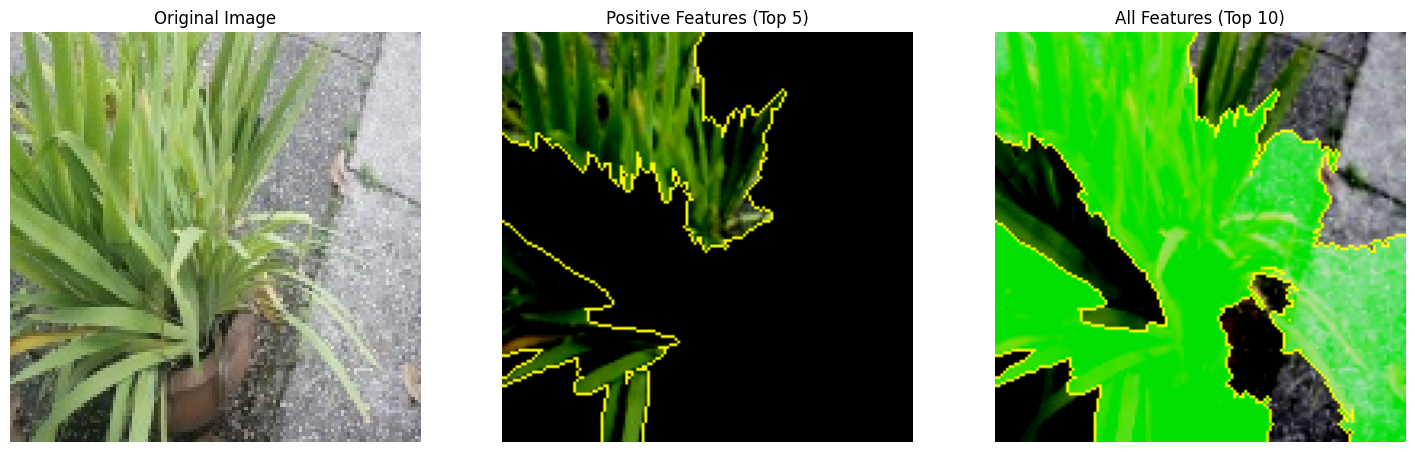

In [59]:
test_temp_1, test_mask_1 = test_explanation.get_image_and_mask(test_explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

# To get an overlay of the superpixels with positive influence, we change the arguments positive_only and hide_rest to False
test_temp_2, test_mask_2 = test_explanation.get_image_and_mask(test_explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(test_image_orig)
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(mark_boundaries(test_temp_1, test_mask_1))
ax2.set_title('Positive Features (Top 5)')
ax2.axis('off')

ax3.imshow(mark_boundaries(test_temp_2, test_mask_2))
ax3.set_title('All Features (Top 10)')
ax3.axis('off')

# plt.show()
plt.savefig('plots/inceptionv3_model_explanations_test_class29.png')

### Integrating explainability using SHAP

In [ ]:
train_image_orig